In [1]:
!git clone https://github.com/syukrighazali95/Metal_Corrosion_Classification.git

Cloning into 'Metal_Corrosion_Classification'...
remote: Enumerating objects: 1143, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 1143 (delta 55), reused 164 (delta 53), pack-reused 977
Receiving objects: 100% (1143/1143), 354.93 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Updating files: 100% (1905/1905), done.


In [2]:
### We create a bunch of helpful functions throughout the course.
### Storing them here so they're easily accessible.

import tensorflow as tf

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  
# Create function to unzip a zipfile into current working directory 
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

def load_keras_image(model, img_path, target_size=(224, 224)):
  import keras.utils as image
# Read the image and resize it
  img = image.load_img(img_path, target_size=(224, 224))
  plt.imshow(img)

  # Convert it to a Numpy array with shape (150, 150, 3)
  test_x = image.img_to_array(img)

  # Reshape it to (1, 150, 150, 3)
  test_x = test_x.reshape((1,) + test_x.shape)

  # Normalize the image (we need to do this as we did this same step while training the # model)
  test_x = test_x.astype('float32') / 255
  rust_prob = model.predict(test_x)

  if (rust_prob > 0.62):
      print("This is a rust image")
  else:
      print("This is a no rust image")


In [3]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

In [4]:
train_dir = "../content/Metal_Corrosion_Classification/Datasets/Classification datasets/train"
test_dir = "../content/Metal_Corrosion_Classification/Datasets/Classification datasets/test"

walk_through_dir("../content/Metal_Corrosion_Classification/Datasets/Classification datasets")

There are 2 directories and 0 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets'.
There are 2 directories and 0 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets/train'.
There are 0 directories and 228 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets/train/norust'.
There are 0 directories and 228 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets/train/rust'.
There are 2 directories and 0 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets/test'.
There are 0 directories and 57 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets/test/norust'.
There are 0 directories and 57 images in '../content/Metal_Corrosion_Classification/Datasets/Classification datasets/test/rust'.


In [5]:
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "binary",
    image_size=IMG_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="binary",
    image_size=IMG_SIZE
)

input_shape = (224,224,3)

Found 456 files belonging to 2 classes.
Found 114 files belonging to 2 classes.


In [6]:
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.Rescaling(scale=1./255)
], name="augmented_layer")

base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [7]:
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)


In [8]:
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(lr=0.02),
    metrics=["accuracy"]
)

initial_epoch = 0

In [9]:
fine_tune_epochs = initial_epoch + 7

history = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),
    initial_epoch=initial_epoch,
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="fine_tune_all_classes")]
    )

results = model.evaluate(test_data)

model.save("rust_binary_v2.h5")

Saving TensorBoard log files to: transfer_learning/fine_tune_all_classes/20230408-093934
Epoch 1/7
15/15 [==============================] - 79s 5s/step - loss: 0.6753 - accuracy: 0.5811 - val_loss: 0.6451 - val_accuracy: 0.6562
Epoch 2/7
15/15 [==============================] - 64s 4s/step - loss: 0.6036 - accuracy: 0.7895 - val_loss: 0.5908 - val_accuracy: 0.7812
Epoch 3/7
15/15 [==============================] - 57s 4s/step - loss: 0.5587 - accuracy: 0.8246 - val_loss: 0.5688 - val_accuracy: 0.7500
Epoch 4/7
15/15 [==============================] - 53s 3s/step - loss: 0.5244 - accuracy: 0.8268 - val_loss: 0.5143 - val_accuracy: 0.7812
Epoch 5/7
15/15 [==============================] - 57s 4s/step - loss: 0.4932 - accuracy: 0.8443 - val_loss: 0.5173 - val_accuracy: 0.7188
Epoch 6/7
15/15 [==============================] - 56s 4s/step - loss: 0.4697 - accuracy: 0.8421 - val_loss: 0.4731 - val_accuracy: 0.8750
Epoch 7/7
4/4 [==============================] - 7s 949ms/step - loss: 0.4465

In [10]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import os

In [11]:
train_dir = "/content/Metal_Corrosion_Classification/Datasets/Classification datasets/train"
test_dir = "/content/Metal_Corrosion_Classification/Datasets/Classification datasets/test"

In [12]:
IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode = "binary",
    image_size=IMG_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="binary",
    image_size=IMG_SIZE
)

Found 456 files belonging to 2 classes.
Found 114 files belonging to 2 classes.


In [13]:
class_names = test_data.class_names

model = tf.keras.models.load_model("rust_binary_v2.h5")
print(model.summary())

model.evaluate(test_data)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmented_layer (Sequential  (None, None, None, 3)    0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling_laye  (None, 512)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable 

[0.4465387463569641, 0.8333333134651184]

In [14]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmented_layer (Sequential  (None, None, None, 3)    0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling_laye  (None, 512)              0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable 

In [15]:
model.evaluate(test_data)

4/4 [==============================] - 2s 124ms/step - loss: 0.4465 - accuracy: 0.8333


[0.44653868675231934, 0.8333333134651184]

In [16]:
img_path = '/content/Metal_Corrosion_Classification/Datasets/Google Image/Rust/1.jpg'


1/1 [==============================] - 1s 736ms/step
This is a rust image


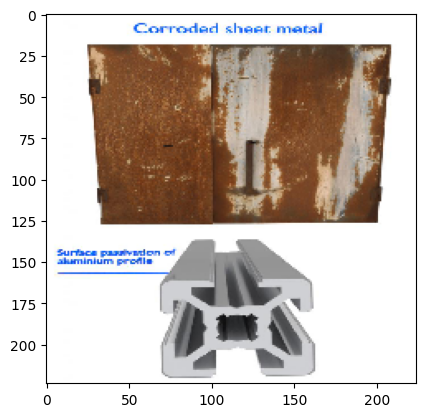

In [17]:
import keras.utils as image
load_keras_image(model, img_path, target_size=(224, 224))
